In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder as OHE
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.sparse as sparse
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from keras import backend as K
import h3pandas

In [3]:
# loading the data
df_main = pd.read_csv("taxi_2017_complete_preprocessed.csv")
df_main .head()

,Unnamed: 0,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.0,1.703108e+10,1.703108e+10,8,8,13.25,...,POINT (-87.6262149064 41.8925077809),2751,30.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
1,1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.7,NaN,NaN,2,3,10.00,...,POINT (-87.6558787862 41.96581197),5058,11.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
2,2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.5,NaN,NaN,16,16,4.50,...,POINT (-87.7234523905 41.9535821253),5047,2.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
3,3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.3,1.703184e+10,1.703183e+10,32,28,6.25,...,POINT (-87.6572331997 41.8852813201),2416,4.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
4,4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.0,1.703128e+10,1.703184e+10,28,32,6.00,...,POINT (-87.6327464887 41.8809944707),3952,7.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1


In [3]:
# making sure we see all columns, and getting rid of certain warnings
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [4]:
# choosing the variables we will use for training. 
work_data = df_main.loc[:, ("start_census","hour","start_latitude","start_longitude","weekday","day","month")]
work_data = work_data.dropna()
# renaming to lat and lng, we need this for calculating the h3 hexagons. 
work_data["lat"] = work_data["start_latitude"]
work_data["lng"] = work_data["start_longitude"]
work_data = work_data.drop('start_latitude', axis=1)
work_data = work_data.drop('start_longitude', axis=1)
work_data

,start_census,hour,weekday,day,month,lat,lng
0,1.703108e+10,0,6,1,1,41.893216,-87.637844
3,1.703184e+10,0,6,1,1,41.880994,-87.632746
4,1.703128e+10,0,6,1,1,41.879255,-87.642649
5,1.703108e+10,0,6,1,1,41.900221,-87.629105
6,1.703184e+10,0,6,1,1,41.880994,-87.632746
...,...,...,...,...,...,...,...
21737159,1.703108e+10,23,6,31,12,41.892042,-87.631864
21737160,1.703108e+10,23,6,31,12,41.892508,-87.626215
21737162,1.703108e+10,23,6,31,12,41.891972,-87.612945
21737163,1.703124e+10,23,6,31,12,41.906026,-87.675312


In [5]:
# method for processing the dataset. Calculate h3 and hour buckets, aswell as the target variable.
def create_dataset_more_data2(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    # decide whether or not we want to use h3.+
    if use_h3:
        # calculater h3.
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
    
        # choose variables we want to use.
        df = df.loc[:, ("start_census","weekday","hour","month", "h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df = df.dropna()
        #print(df.head())
        
        # calculate hour buckets.
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            # i am aware that this does not hold any information, but its easier 
            # than getting rid of the variable alltogether, and it does no harm
            df['new_hour'] = np.zeros(df.shape[0])
        
        df2 = df.loc[:, ("start_census","weekday","new_hour","month","h3")]
        df2["temp"] = 0
        # calculate demand = occurrences
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","month","h3"]).transform('count')
        # we drop all duplicates as there are a lot of them. We go from 10.000.000 to about 300.000 data points.
        df2.drop_duplicates(inplace=True)

        # one hot encoding for all categorical variables. 
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","month","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","month","h3")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
    else:
        # choose the variables we want to use.
        df = df.loc[:, ("start_census","weekday","hour","month")].copy()
        df = df.dropna()

        # calculate hour buckets.
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            # i am aware that this does not hold any information, but its easier 
            # than getting rid of the variable alltogether, and it does no harm
            df['new_hour'] = np.zeros(df.shape[0])

        df2 = df.loc[:, ("start_census","weekday","new_hour","month")]
        df2["temp"] = 0
        # calculate demand = occurrences
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","month"]).transform('count')

        
        df2.drop_duplicates(inplace=True)
    
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","month")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","month")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
        

In [6]:
# method for processing the dataset. Calculate h3 and hour buckets, aswell as the target variable.
def create_dataset_more_data(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
     # decide whether or not we want to use h3.
    if use_h3:
         # calculater h3.
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
    
           # choose variables we want to use.
        df = df.loc[:, ("start_census","weekday","hour","day","month", "h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df = df.dropna()

        
             # calculate hour buckets.
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            # i am aware that this does not hold any information, but its easier 
            # than getting rid of the variable alltogether, and it does no harm
            df['new_hour'] = np.zeros(df.shape[0])

        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month","h3")]
        df2["temp"] = 0
        
        # calculate demand = occurrences
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month","h3"]).transform('count')
        # we drop all duplicates as there are a lot of them. We go from 10.000.000 to about ~300.000 data points,
        # depending on hour resolution
        df2.drop_duplicates(inplace=True)
        
        # one hot encoding for all categorical variables. 
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
    else:
        # choose the variables we want to use.
        df = df.loc[:, ("start_census","weekday","hour","day","month")].copy()
        df = df.dropna()
        
        # calculate hour buckets.
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            # i am aware that this does not hold any information, but its easier 
            # than getting rid of the variable alltogether, and it does no harm
            df['new_hour'] = np.zeros(df.shape[0])


        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month")]
        df2["temp"] = 0
        # we drop all duplicates as there are a lot of them. We go from 10.000.000 to about 300.000 data points.
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month"]).transform('count')
        
        # drop duplicates 
        df2.drop_duplicates(inplace=True)
        
        # one hot encoding for all categorical variables. 
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data      

In [7]:
# this activates early stopping using the val_loss as metric. If the model did not improve the val loss for 10 times in
# a row, the model stops and loads the best model weights (based on the val loss).
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [8]:
# class that takes care of the training.
class Train_Net:
    def __init__(self, data, network, tt_size = 0.2, validation_size=0.2,
                 learning_rate = 0.01, momentum = 0.9, batch_size = 128, epochs = 5):
        self.data = data
        self.tt_size = tt_size
        self.validation_size = validation_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.network = network
        self.batch_size = batch_size
        self.epochs = epochs
     
    
    
    def train_net(self):
        # train test split.
        train, test = train_test_split(self.data, test_size=self.tt_size)
        
        
        # getting x and y values.
        X_train = train[:,0:-1]
        Y_train = train[:,-1:]
        X_test = test[:,0:-1]
        Y_test = test[:,-1:]
        
        # setting the network hyperparameter.
        self.network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum),
                             loss='mean_absolute_error')
        
        # the training step.
        H = self.network.fit(X_train, Y_train, epochs=self.epochs, batch_size=self.batch_size, 
                             validation_split=self.validation_size, callbacks=[callback])
        print("Testset:")
        print()
        
        # evaluate model on test set.
        test_loss = self.network.evaluate(X_test, Y_test)
        print("Test Loss: ", test_loss)
        
        # plotting the test and val loss.
        plt.style.use("ggplot")
        plt.figure()
        epochs_plot = self.epochs
        if callback.stopped_epoch != 0:
            epochs_plot = callback.stopped_epoch + 1
        
        plt.plot(np.arange(0,epochs_plot), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs_plot), H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        return test_loss, H, epochs_plot
    

(376367, 601)
lr:  0.01  Hour_res:  1
Epoch 1/200
471/471 [==============================] - 21s 23ms/step - loss: 12.9808 - val_loss: 7.6784
Epoch 2/200
471/471 [==============================] - 11s 22ms/step - loss: 6.6681 - val_loss: 6.0966
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 6.0400 - val_loss: 5.8731
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 5.5854 - val_loss: 5.3964
Epoch 5/200
471/471 [==============================] - 12s 25ms/step - loss: 5.4336 - val_loss: 5.3773
Epoch 6/200
471/471 [==============================] - 10s 22ms/step - loss: 5.2163 - val_loss: 5.6852
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 5.1344 - val_loss: 5.0480
Epoch 8/200
471/471 [==============================] - 10s 22ms/step - loss: 4.9866 - val_loss: 5.2084
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 4.9506 - val_loss: 5.9342
Epoch 10/200
471/471 [============

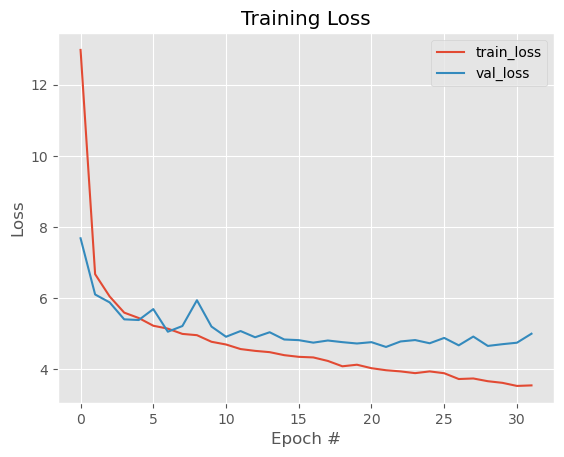

(230188, 589)
lr:  0.01  Hour_res:  2
Epoch 1/200
288/288 [==============================] - 7s 22ms/step - loss: 25.9043 - val_loss: 12.8943
Epoch 2/200
288/288 [==============================] - 6s 21ms/step - loss: 12.0736 - val_loss: 10.0473
Epoch 3/200
288/288 [==============================] - 6s 21ms/step - loss: 10.0434 - val_loss: 9.0173
Epoch 4/200
288/288 [==============================] - 6s 22ms/step - loss: 9.3420 - val_loss: 8.4346
Epoch 5/200
288/288 [==============================] - 6s 21ms/step - loss: 8.6791 - val_loss: 8.1861
Epoch 6/200
288/288 [==============================] - 6s 21ms/step - loss: 8.4231 - val_loss: 8.6518
Epoch 7/200
288/288 [==============================] - 6s 21ms/step - loss: 8.0015 - val_loss: 8.2907
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: 7.9935 - val_loss: 8.1385
Epoch 9/200
288/288 [==============================] - 6s 21ms/step - loss: 7.8476 - val_loss: 7.8875
Epoch 10/200
288/288 [=================

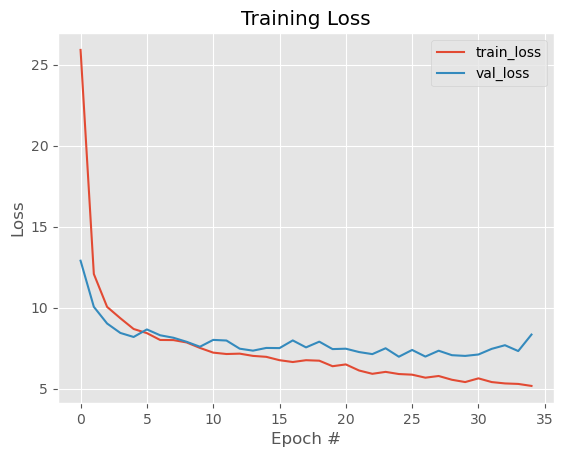

(108943, 581)
lr:  0.01  Hour_res:  6
Epoch 1/200
137/137 [==============================] - 3s 23ms/step - loss: 88.2704 - val_loss: 87.7586
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 88.8764 - val_loss: 87.7194
Epoch 3/200
137/137 [==============================] - 3s 21ms/step - loss: 88.8372 - val_loss: 87.7301
Epoch 4/200
137/137 [==============================] - 3s 21ms/step - loss: 88.6289 - val_loss: 87.7464
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 88.7591 - val_loss: 87.7281
Epoch 6/200
137/137 [==============================] - 3s 22ms/step - loss: 88.8817 - val_loss: 92.7071
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: 89.3984 - val_loss: 87.8178
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: 88.8896 - val_loss: 87.6905
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: 88.7960 - val_loss: 87.6923
Epoch 10/200
137/137 [====

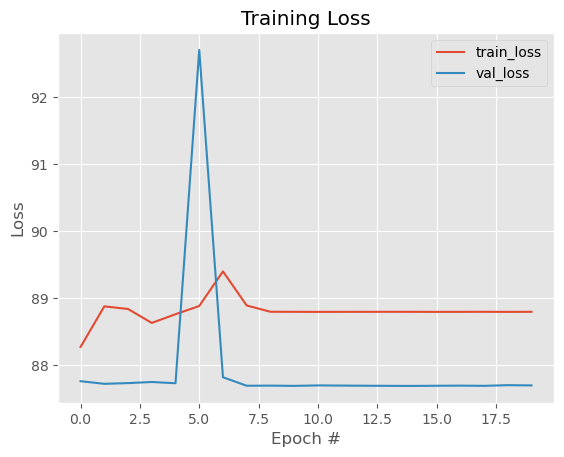

(46106, 578)
lr:  0.01  Hour_res:  24
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: 215.4824 - val_loss: 208.0399
Epoch 2/200
58/58 [==============================] - 1s 22ms/step - loss: 213.3768 - val_loss: 208.3713
Epoch 3/200
58/58 [==============================] - 1s 22ms/step - loss: 214.8837 - val_loss: 208.2831
Epoch 4/200
58/58 [==============================] - 1s 22ms/step - loss: 214.7358 - val_loss: 207.7672
Epoch 5/200
58/58 [==============================] - 1s 21ms/step - loss: 214.7724 - val_loss: 207.5671
Epoch 6/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6544 - val_loss: 208.7056
Epoch 7/200
58/58 [==============================] - 1s 21ms/step - loss: 214.8772 - val_loss: 207.6058
Epoch 8/200
58/58 [==============================] - 1s 22ms/step - loss: 214.7064 - val_loss: 209.3039
Epoch 9/200
58/58 [==============================] - 1s 22ms/step - loss: 215.1873 - val_loss: 208.4946
Epoch 10/200
58/58 [======

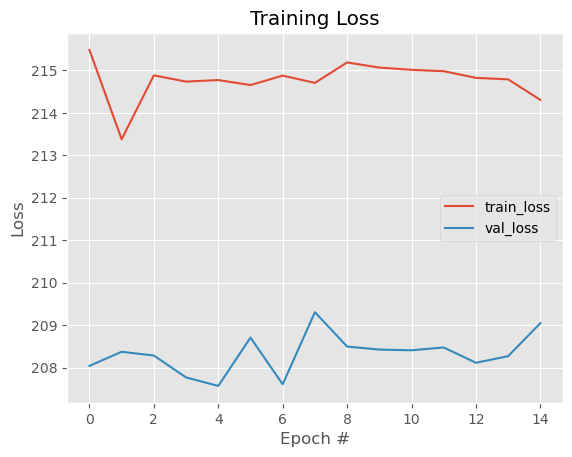

(376367, 601)
lr:  0.03  Hour_res:  1
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.9407 - val_loss: 23.5823
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8313 - val_loss: 23.6083
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8239 - val_loss: 23.6077
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8237 - val_loss: 23.6083
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8231 - val_loss: 23.6083
Epoch 6/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8236 - val_loss: 23.6089
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8235 - val_loss: 23.6084
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8233 - val_loss: 23.6088
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 23.8234 - val_loss: 23.6086
Epoch 10/200
471/

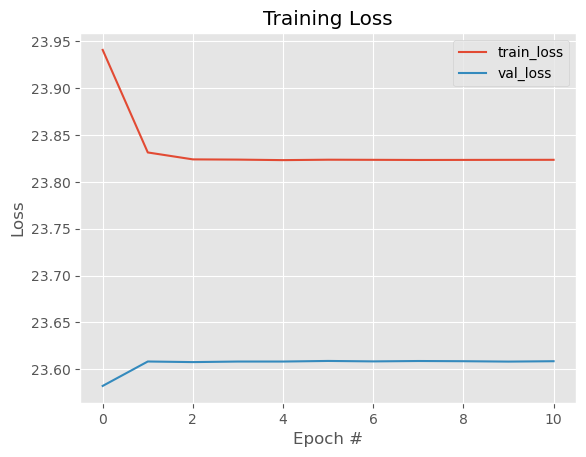

(230188, 589)
lr:  0.03  Hour_res:  2
Epoch 1/200
288/288 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
E

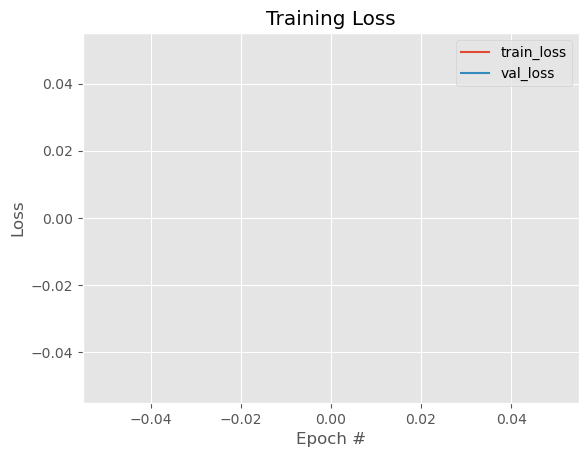

(108943, 581)
lr:  0.03  Hour_res:  6
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 88.4450 - val_loss: 89.8089
Epoch 2/200
137/137 [==============================] - 3s 22ms/step - loss: 89.7268 - val_loss: 90.9243
Epoch 3/200
137/137 [==============================] - 4s 26ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 25ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 21ms/step - loss: nan -

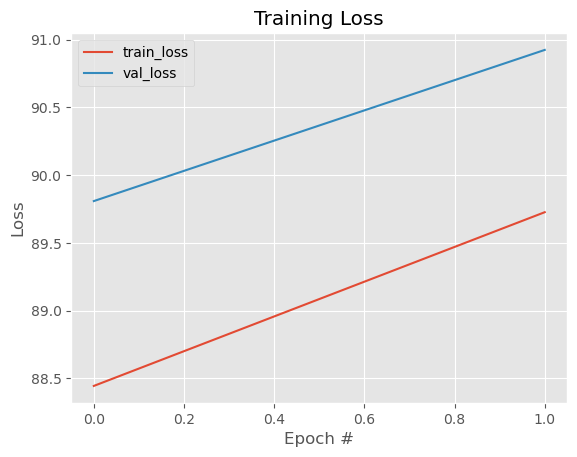

(46106, 578)
lr:  0.03  Hour_res:  24
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: 212.2902 - val_loss: 212.7134
Epoch 2/200
58/58 [==============================] - 1s 23ms/step - loss: 216.3940 - val_loss: 216.1982
Epoch 3/200
58/58 [==============================] - 1s 23ms/step - loss: 212.2010 - val_loss: 216.1686
Epoch 4/200
58/58 [==============================] - 1s 22ms/step - loss: 212.0788 - val_loss: 216.1609
Epoch 5/200
58/58 [==============================] - 1s 22ms/step - loss: 212.0438 - val_loss: 216.0156
Epoch 6/200
58/58 [==============================] - 1s 22ms/step - loss: 212.1119 - val_loss: 216.1665
Epoch 7/200
58/58 [==============================] - 1s 23ms/step - loss: 212.1116 - val_loss: 216.1685
Epoch 8/200
58/58 [==============================] - 1s 23ms/step - loss: 212.1070 - val_loss: 216.1741
Epoch 9/200
58/58 [==============================] - 1s 23ms/step - loss: 212.1138 - val_loss: 216.1631
Epoch 10/200
58/58 [======

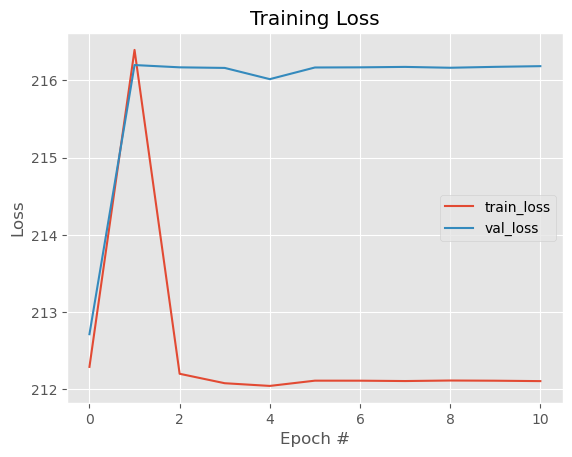

(376367, 601)
lr:  0.05  Hour_res:  1
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 24.1781 - val_loss: 26.8119
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 10s 22ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 10s 21ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 10s 21ms/step - loss: nan

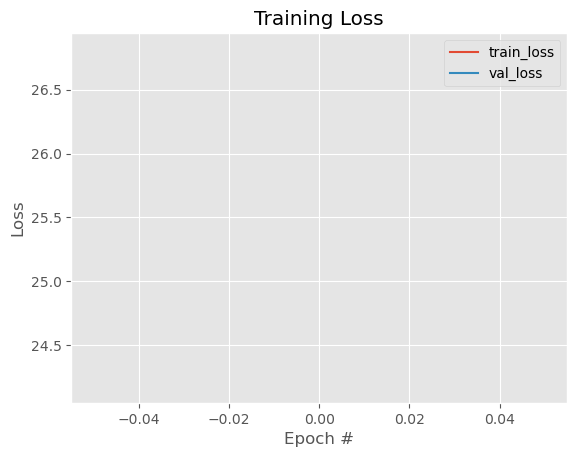

(230188, 589)
lr:  0.05  Hour_res:  2
Epoch 1/200
288/288 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 22ms/step - loss: nan - val_loss: nan
E

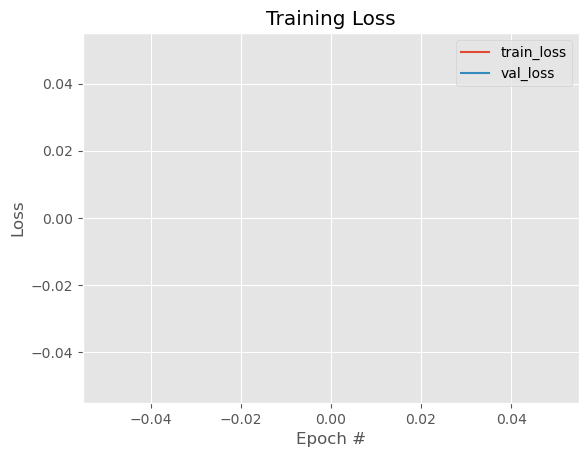

(108943, 581)
lr:  0.05  Hour_res:  6
Epoch 1/200
137/137 [==============================] - 3s 23ms/step - loss: 89.6609 - val_loss: 84.6840
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 89.5341 - val_loss: 84.7788
Epoch 3/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4814 - val_loss: 84.6882
Epoch 4/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4934 - val_loss: 84.6674
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4751 - val_loss: 84.6600
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4846 - val_loss: 84.6598
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4823 - val_loss: 84.6664
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4811 - val_loss: 84.6690
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: 89.4802 - val_loss: 84.6593
Epoch 10/200
137/137 [====

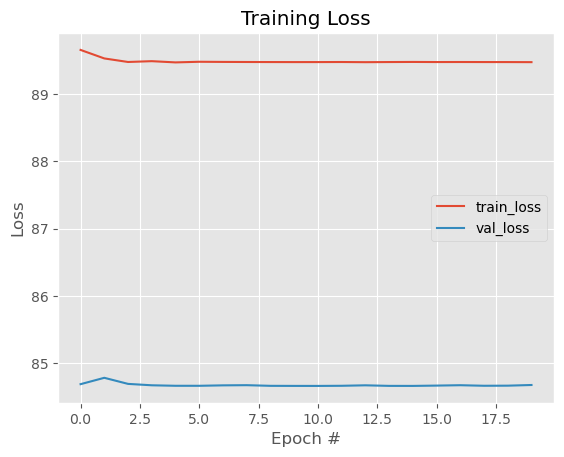

(46106, 578)
lr:  0.05  Hour_res:  24
Epoch 1/200
58/58 [==============================] - 2s 26ms/step - loss: 215.1933 - val_loss: 213.0328
Epoch 2/200
58/58 [==============================] - 1s 23ms/step - loss: 215.1764 - val_loss: 212.8358
Epoch 3/200
58/58 [==============================] - 1s 23ms/step - loss: 214.9900 - val_loss: 212.8973
Epoch 4/200
58/58 [==============================] - 1s 23ms/step - loss: 214.8986 - val_loss: 212.6974
Epoch 5/200
58/58 [==============================] - 1s 23ms/step - loss: 214.9051 - val_loss: 212.7422
Epoch 6/200
58/58 [==============================] - 1s 23ms/step - loss: 214.9174 - val_loss: 212.8204
Epoch 7/200
58/58 [==============================] - 1s 23ms/step - loss: 214.8878 - val_loss: 212.6686
Epoch 8/200
58/58 [==============================] - 1s 23ms/step - loss: 214.8648 - val_loss: 212.7580
Epoch 9/200
58/58 [==============================] - 2s 27ms/step - loss: 214.8859 - val_loss: 212.7603
Epoch 10/200
58/58 [======

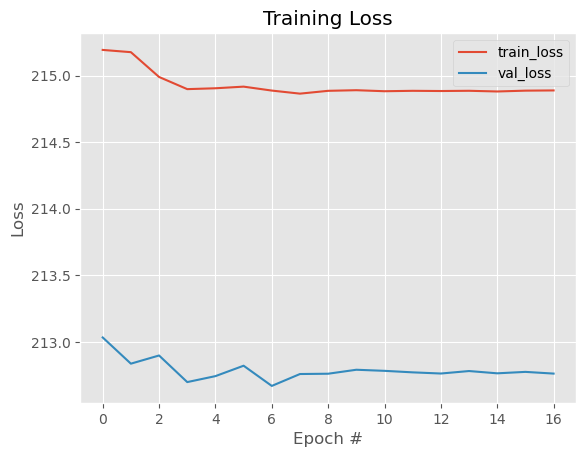

['lr: 0.01 Hour_res: 1 Epochs before stopping:32 Test_loss: 4.6294121742248535 Demand mean value: 26.56981084951656',
 'lr: 0.01 Hour_res: 2 Epochs before stopping:35 Test_loss: 7.033663749694824 Demand mean value: 43.44275114254435',
 'lr: 0.01 Hour_res: 6 Epochs before stopping:20 Test_loss: 89.11892700195312 Demand mean value: 91.79112012703891',
 'lr: 0.01 Hour_res: 24 Epochs before stopping:15 Test_loss: 212.92396545410156 Demand mean value: 216.8915108662647',
 'lr: 0.03 Hour_res: 1 Epochs before stopping:11 Test_loss: 23.664520263671875 Demand mean value: 26.56981084951656',
 'lr: 0.03 Hour_res: 2 Epochs before stopping:10 Test_loss: nan Demand mean value: 43.44275114254435',
 'lr: 0.03 Hour_res: 6 Epochs before stopping:11 Test_loss: 87.77578735351562 Demand mean value: 91.79112012703891',
 'lr: 0.03 Hour_res: 24 Epochs before stopping:11 Test_loss: 212.33035278320312 Demand mean value: 216.8915108662647',
 'lr: 0.05 Hour_res: 1 Epochs before stopping:11 Test_loss: 27.066806793

In [9]:
# training loop, these are the parameters we tested when not! using h3.
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
result_list = []
# sample of 10.000.000 as my computer struggles otherwise.
data_sample = work_data.sample(10000000,random_state=101)
for i in lr:
    for j in resolution:
        # call the function for creating the dataset.
        data1 = create_dataset_more_data(data_sample,resolution=j,use_h3=False)
        print(data1.shape)
        
        # defining the network we use.
        network1 = models.Sequential()
        network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(1, activation='linear'))
         
        print("lr: ", i, " Hour_res: ", j)
        # training using the hyperparameters from the loops.
        TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
        loss, H, epochs_plot = TN1.train_net()
        
        # saving results.
        result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list

(376510, 602)
lr:  0.01  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 23.6488 - val_loss: 22.8792
Epoch 2/200
471/471 [==============================] - 10s 20ms/step - loss: 10.7060 - val_loss: 7.8481
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 7.3692 - val_loss: 7.3780
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 6.4835 - val_loss: 6.0840
Epoch 5/200
471/471 [==============================] - 10s 20ms/step - loss: 6.0361 - val_loss: 6.2531
Epoch 6/200
471/471 [==============================] - 10s 20ms/step - loss: 5.7108 - val_loss: 5.7211
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 5.4365 - val_loss: 5.4891
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.3030 - val_loss: 5.2618
Epoch 9/200
471/471 [==============================] - 10s 20ms/step - loss: 5.1948 - val_loss: 5.4348
Epoch 10/200
471/471

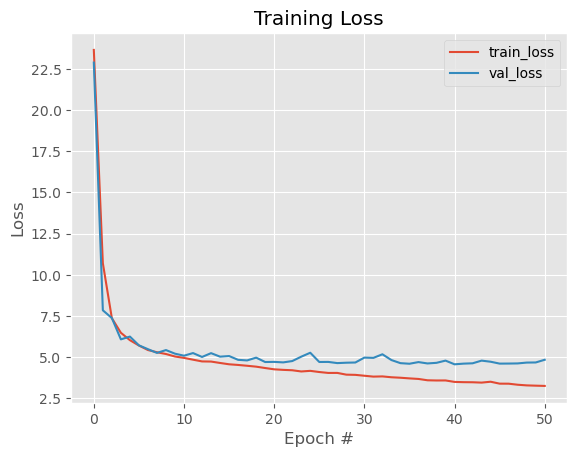

(376510, 608)
lr:  0.01  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 23.3178 - val_loss: 23.1083
Epoch 2/200
471/471 [==============================] - 9s 20ms/step - loss: 18.5225 - val_loss: 9.8870
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 8.4884 - val_loss: 9.0057
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: 6.9810 - val_loss: 6.5010
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: 6.3181 - val_loss: 5.8790
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.8701 - val_loss: 5.6054
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 5.6576 - val_loss: 5.6018
Epoch 8/200
471/471 [==============================] - 9s 20ms/step - loss: 5.5768 - val_loss: 5.3776
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 5.4008 - val_loss: 5.5212
Epoch 10/200
471/471 [====

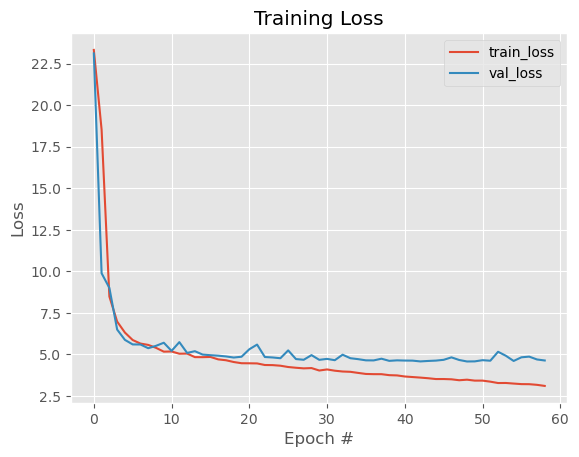

(376510, 708)
lr:  0.01  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 12s 25ms/step - loss: 11.2368 - val_loss: 6.9746
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 6.5005 - val_loss: 5.9266
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9301 - val_loss: 5.8026
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 5.6089 - val_loss: 5.8013
Epoch 5/200
471/471 [==============================] - 10s 22ms/step - loss: 5.4083 - val_loss: 5.3629
Epoch 6/200
471/471 [==============================] - 11s 22ms/step - loss: 5.1960 - val_loss: 5.2633
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.0523 - val_loss: 5.3928
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9337 - val_loss: 5.2926
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 4.8384 - val_loss: 5.0524
Epoch 10/200
471/471 

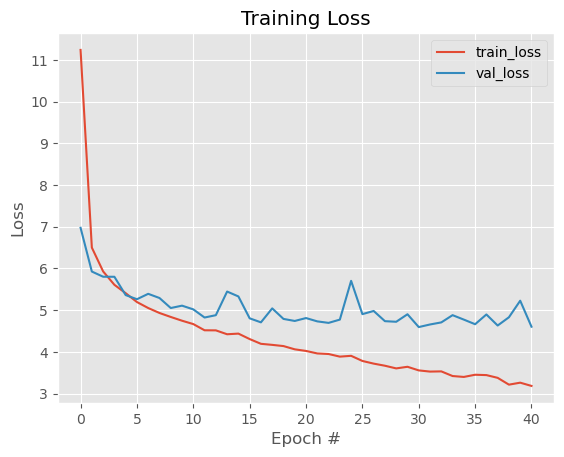

(230311, 590)
lr:  0.01  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 7s 23ms/step - loss: 40.1150 - val_loss: 40.6633
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2603 - val_loss: 42.1980
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 40.4083 - val_loss: 40.6727
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2687 - val_loss: 40.6563
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2679 - val_loss: 40.6562
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2676 - val_loss: 40.6560
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2683 - val_loss: 40.6561
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: 40.2661 - val_loss: 40.6562
Epoch 9/200
288/288 [==============================] - 7s 23ms/step - loss: 40.2673 - val_loss: 40.6560
Epoch 10/200


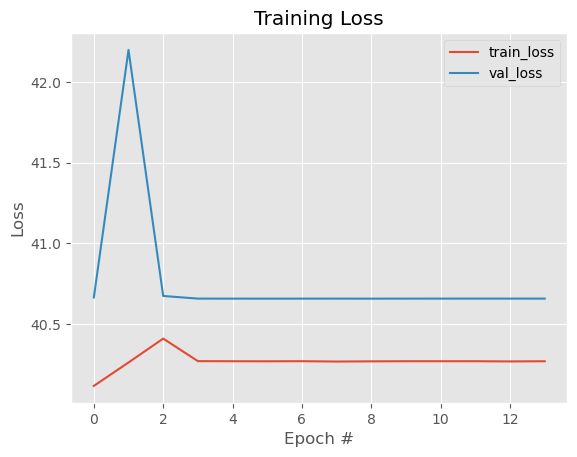

(230311, 596)
lr:  0.01  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 7s 22ms/step - loss: 39.9236 - val_loss: 38.4767
Epoch 2/200
288/288 [==============================] - 6s 21ms/step - loss: 40.1890 - val_loss: 41.0360
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 38.8096 - val_loss: 38.8289
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 38.1592 - val_loss: 39.2584
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 26.7418 - val_loss: 19.1570
Epoch 6/200
288/288 [==============================] - 6s 19ms/step - loss: 14.8180 - val_loss: 14.5076
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 12.4848 - val_loss: 11.5646
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: 10.8637 - val_loss: 9.9845
Epoch 9/200
288/288 [==============================] - 6s 22ms/step - loss: 9.8660 - val_loss: 9.5741
Epoch 10/200
288

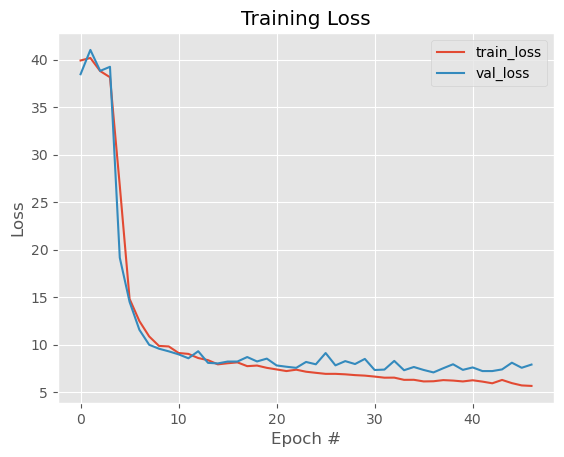

(230311, 696)
lr:  0.01  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 10s 21ms/step - loss: 21.8331 - val_loss: 13.3271
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 11.3040 - val_loss: 9.5561
Epoch 3/200
288/288 [==============================] - 6s 22ms/step - loss: 9.8976 - val_loss: 8.7986
Epoch 4/200
288/288 [==============================] - 6s 22ms/step - loss: 9.0477 - val_loss: 8.6243
Epoch 5/200
288/288 [==============================] - 7s 26ms/step - loss: 8.8462 - val_loss: 10.0937
Epoch 6/200
288/288 [==============================] - 7s 25ms/step - loss: 8.5018 - val_loss: 10.6085
Epoch 7/200
288/288 [==============================] - 7s 24ms/step - loss: 8.3011 - val_loss: 8.2864
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: 7.7489 - val_loss: 8.3328
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: 7.7088 - val_loss: 11.7475
Epoch 10/200
288/288 [==

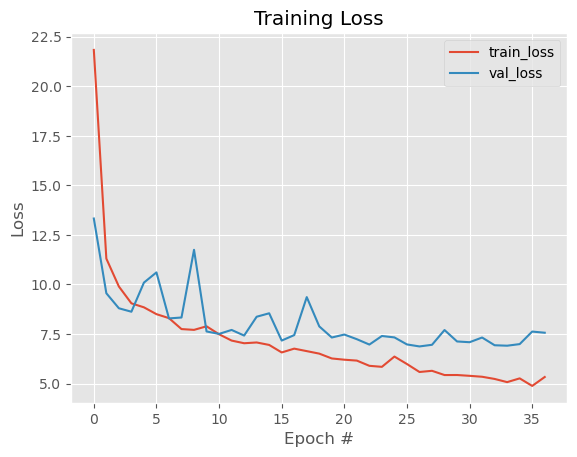

(109080, 582)
lr:  0.01  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 87.8276 - val_loss: 89.4795
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3573 - val_loss: 89.2624
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.2335 - val_loss: 89.4556
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4286 - val_loss: 89.3347
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 88.5408 - val_loss: 90.8566
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3861 - val_loss: 89.2724
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3083 - val_loss: 89.2669
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3066 - val_loss: 89.2677
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3074 - val_loss: 89.2669
Epoch 10/200


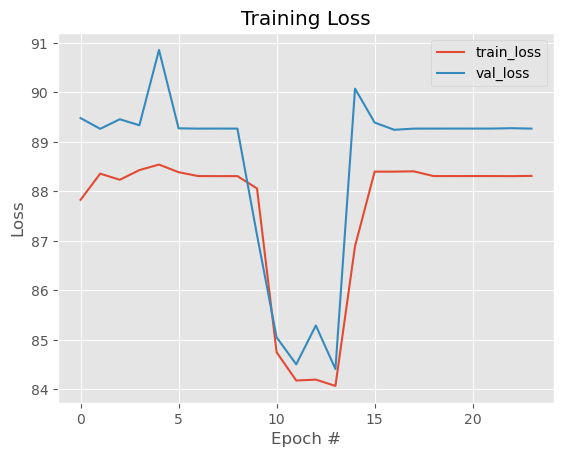

(109080, 588)
lr:  0.01  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 88.4750 - val_loss: 87.7879
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 89.1811 - val_loss: 88.1257
Epoch 3/200
137/137 [==============================] - 4s 26ms/step - loss: 88.3429 - val_loss: 89.3192
Epoch 4/200
137/137 [==============================] - 3s 22ms/step - loss: 85.6376 - val_loss: 77.3170
Epoch 5/200
137/137 [==============================] - 3s 23ms/step - loss: 81.2488 - val_loss: 80.7647
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: 80.7078 - val_loss: 79.2736
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 80.3040 - val_loss: 78.0708
Epoch 8/200
137/137 [==============================] - 3s 23ms/step - loss: 83.9591 - val_loss: 80.3544
Epoch 9/200
137/137 [==============================] - 3s 19ms/step - loss: 80.9374 - val_loss: 81.1701
Epoch 10/200


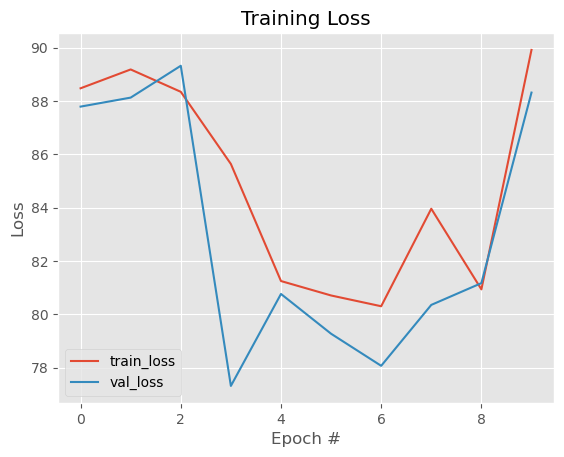

(109080, 688)
lr:  0.01  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 4s 23ms/step - loss: 82.1667 - val_loss: 108.2449
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 86.2388 - val_loss: 78.8956
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 76.8298 - val_loss: 46.5226
Epoch 4/200
137/137 [==============================] - 3s 21ms/step - loss: 37.2239 - val_loss: 34.6080
Epoch 5/200
137/137 [==============================] - 3s 22ms/step - loss: 31.3579 - val_loss: 34.8360
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: 28.0547 - val_loss: 23.5708
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 20.8472 - val_loss: 20.7869
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: 22.1603 - val_loss: 18.9907
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: 19.7079 - val_loss: 21.6978
Epoch 10/200

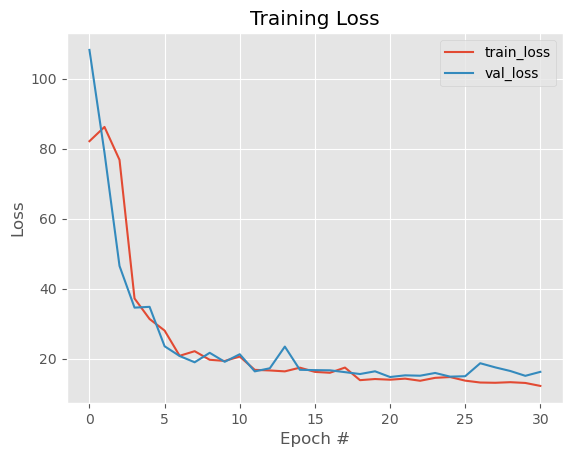

(46168, 579)
lr:  0.01  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 215.2069 - val_loss: 207.4716
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5696 - val_loss: 207.8926
Epoch 3/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6758 - val_loss: 207.6261
Epoch 4/200
58/58 [==============================] - 2s 26ms/step - loss: 214.4224 - val_loss: 207.2372
Epoch 5/200
58/58 [==============================] - 1s 22ms/step - loss: 214.5722 - val_loss: 208.0499
Epoch 6/200
58/58 [==============================] - 1s 21ms/step - loss: 214.8783 - val_loss: 207.8775
Epoch 7/200
58/58 [==============================] - 1s 21ms/step - loss: 214.7470 - val_loss: 207.8070
Epoch 8/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6445 - val_loss: 207.7566
Epoch 9/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6295 - val_loss: 207.7543
Epoch 10/200


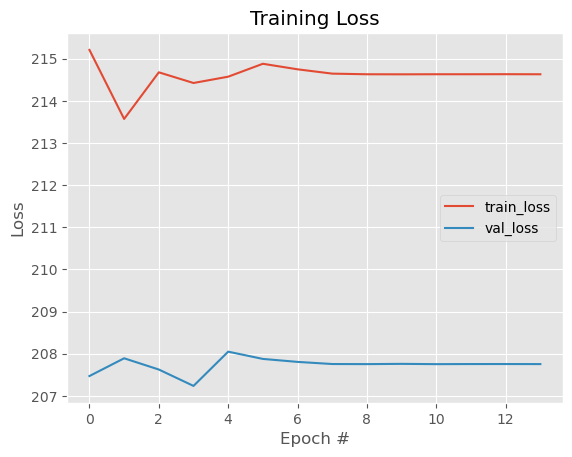

(46168, 585)
lr:  0.01  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 25ms/step - loss: 210.9093 - val_loss: 201.0165
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6998 - val_loss: 207.5376
Epoch 3/200
58/58 [==============================] - 1s 21ms/step - loss: 211.3895 - val_loss: 206.3260
Epoch 4/200
58/58 [==============================] - 1s 21ms/step - loss: 211.3382 - val_loss: 207.2454
Epoch 5/200
58/58 [==============================] - 1s 21ms/step - loss: 210.9613 - val_loss: 205.7983
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: 208.8875 - val_loss: 205.5807
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 211.9880 - val_loss: 208.1700
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 212.1725 - val_loss: 208.1522
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 212.1639 - val_loss: 208.1580
Epoch 10/200


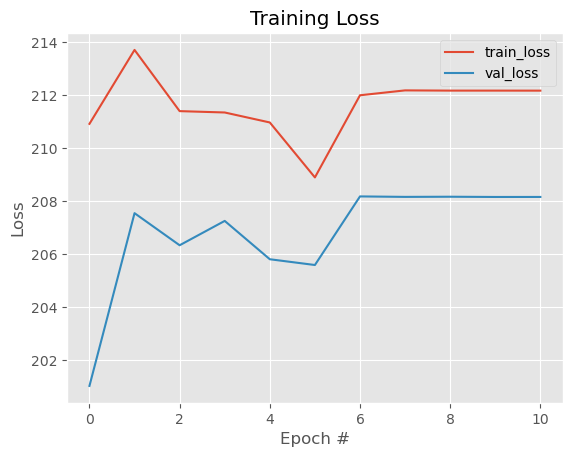

(46168, 685)
lr:  0.01  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 25ms/step - loss: 212.0749 - val_loss: 164.1854
Epoch 2/200
58/58 [==============================] - 1s 21ms/step - loss: 212.4431 - val_loss: 208.4408
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6717 - val_loss: 207.6904
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: 213.7600 - val_loss: 207.7434
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5983 - val_loss: 207.5304
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5883 - val_loss: 207.5759
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5721 - val_loss: 207.7412
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5559 - val_loss: 207.3359
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6561 - val_loss: 208.2513
Epoch 10/200


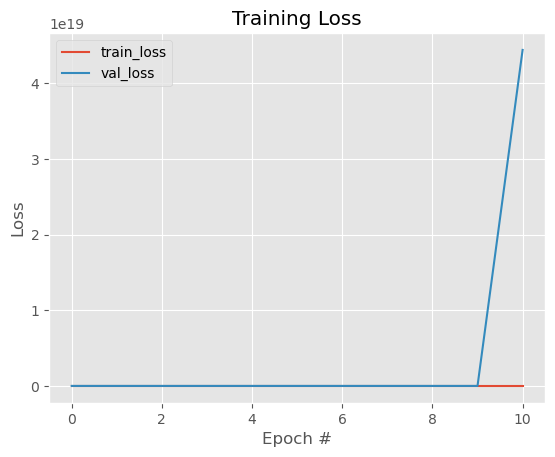

(376510, 602)
lr:  0.03  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8326 - val_loss: 23.8477
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 24.4604 - val_loss: 23.7823
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7676 - val_loss: 23.7826
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7676 - val_loss: 23.7826
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7677 - val_loss: 23.7825
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 23.7677 - val_loss: 23.7822
Epoch 7/200
471/471 [==============================] - 10s 20ms/step - loss: 23.7676 - val_loss: 23.7825
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 23.7677 - val_loss: 23.7824
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 23.7677 - val_loss: 23.7829
Epoch 

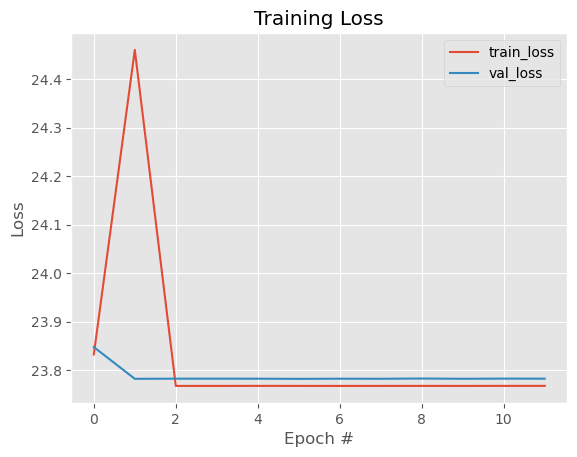

(376510, 608)
lr:  0.03  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7083 - val_loss: 23.5770
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 10s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 11s 22ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - lo

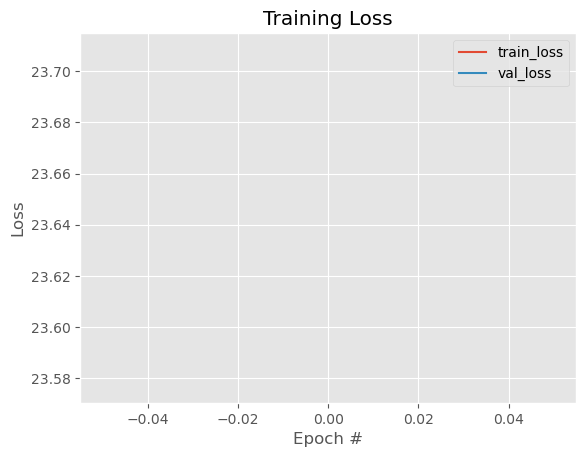

(376510, 708)
lr:  0.03  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 21ms/step - loss: 10.8302 - val_loss: 8.3034
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 7.0798 - val_loss: 6.0355
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 6.3318 - val_loss: 5.8341
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 6.1865 - val_loss: 6.2751
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 5.5927 - val_loss: 5.8529
Epoch 6/200
471/471 [==============================] - 10s 20ms/step - loss: 5.6571 - val_loss: 5.7178
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.4028 - val_loss: 6.9793
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 5.3151 - val_loss: 6.1130
Epoch 9/200
471/471 [==============================] - 11s 22ms/step - loss: 5.2720 - val_loss: 5.3505
Epoch 10/200
471/471 

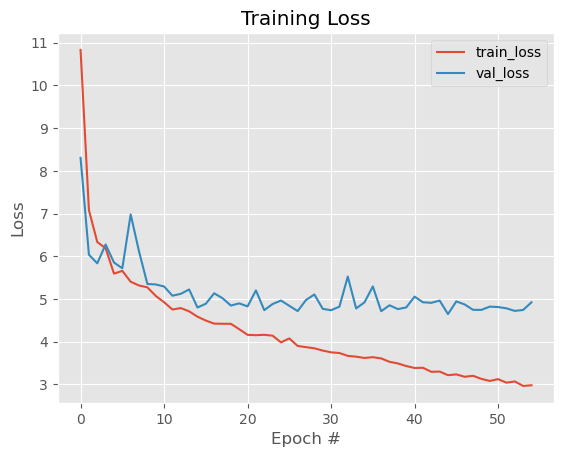

(230311, 590)
lr:  0.03  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 7s 21ms/step - loss: 40.5601 - val_loss: 41.3188
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3609 - val_loss: 41.2987
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3559 - val_loss: 41.2933
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3532 - val_loss: 41.2992
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3564 - val_loss: 41.2988
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3560 - val_loss: 41.2991
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3567 - val_loss: 41.2990
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3555 - val_loss: 41.2990
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3571 - val_loss: 41.2990
Epoch 10/200


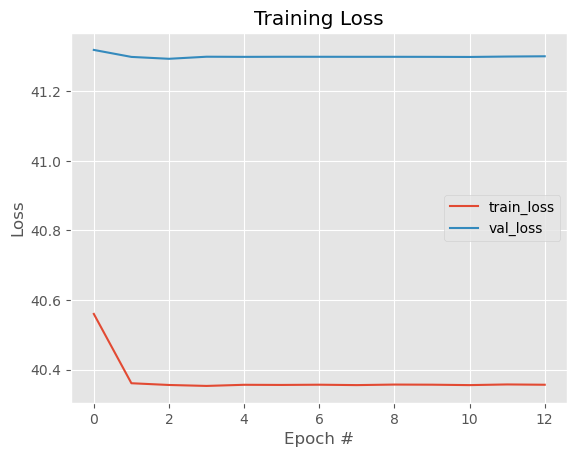

(230311, 596)
lr:  0.03  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3690 - val_loss: 40.0523
Epoch 2/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 20ms/step - loss: 

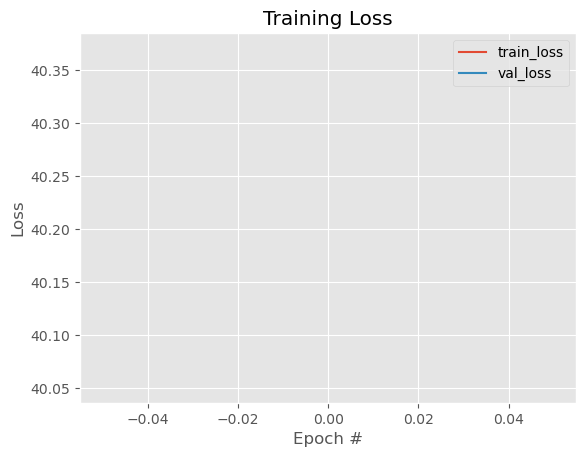

(230311, 696)
lr:  0.03  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 7s 23ms/step - loss: nan - va

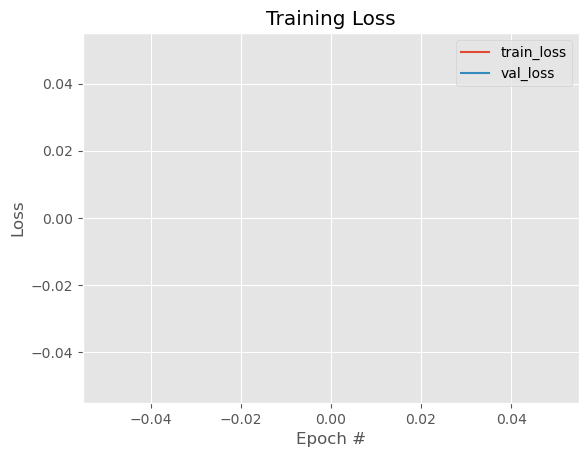

(109080, 582)
lr:  0.03  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 89.3213 - val_loss: 88.0529
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 89.0517 - val_loss: 88.0891
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9989 - val_loss: 87.8555
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9876 - val_loss: 88.0031
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9613 - val_loss: 88.0046
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9579 - val_loss: 88.0040
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9570 - val_loss: 88.0024
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9580 - val_loss: 88.0031
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9581 - val_loss: 88.0023
Epoch 10/200


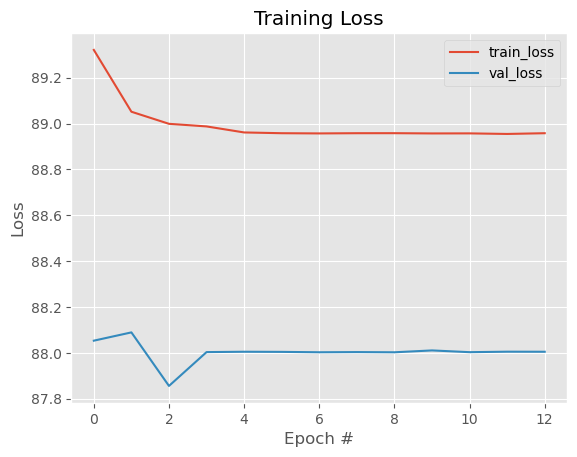

(109080, 588)
lr:  0.03  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 88.8304 - val_loss: 87.4528
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 89.5089 - val_loss: 88.0002
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step 

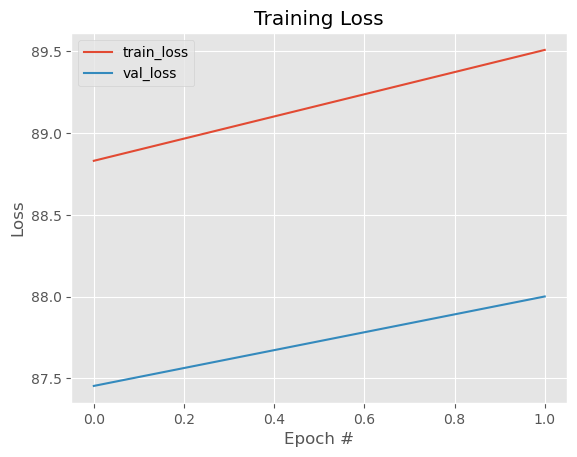

(109080, 688)
lr:  0.03  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 87.1786 - val_loss: 87.9572
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: 

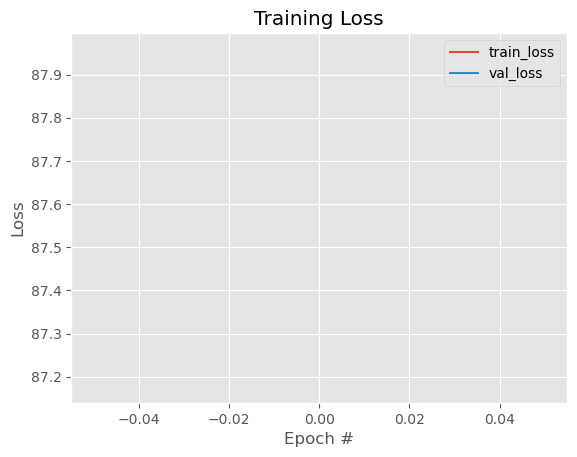

(46168, 579)
lr:  0.03  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 212.9266 - val_loss: 220.4954
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 212.9823 - val_loss: 219.7633
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 212.7586 - val_loss: 219.4854
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: 212.5049 - val_loss: 240.9520
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.8825 - val_loss: 219.7814
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: 212.9634 - val_loss: 219.7318
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 212.8339 - val_loss: 219.6828
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 212.8107 - val_loss: 219.6178
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 212.7696 - val_loss: 219.4903
Epoch 10/200


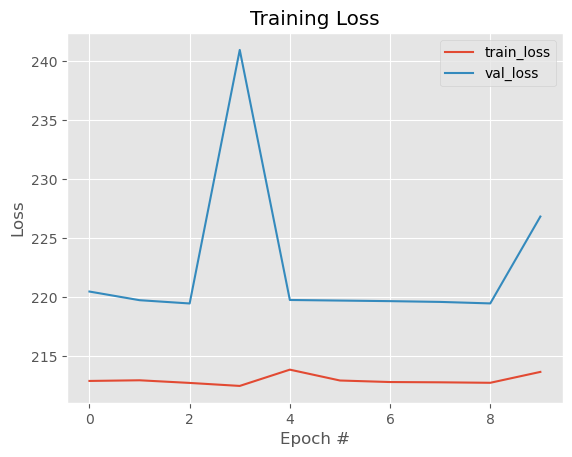

(46168, 585)
lr:  0.03  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 214.0269 - val_loss: 213.5286
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5236 - val_loss: 213.5512
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 213.4585 - val_loss: 212.9871
Epoch 4/200
58/58 [==============================] - 1s 21ms/step - loss: 217.6487 - val_loss: 195.7196
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/s

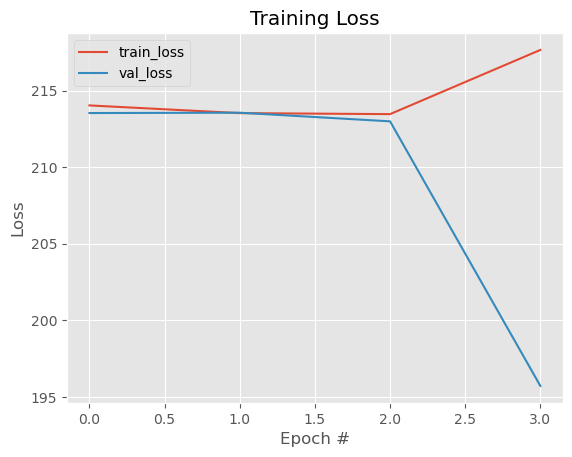

(46168, 685)
lr:  0.03  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: 212.5221 - val_loss: 200.9073
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.4744 - val_loss: 201.1149
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 215.2305 - val_loss: 207.0529
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 21ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/step - loss

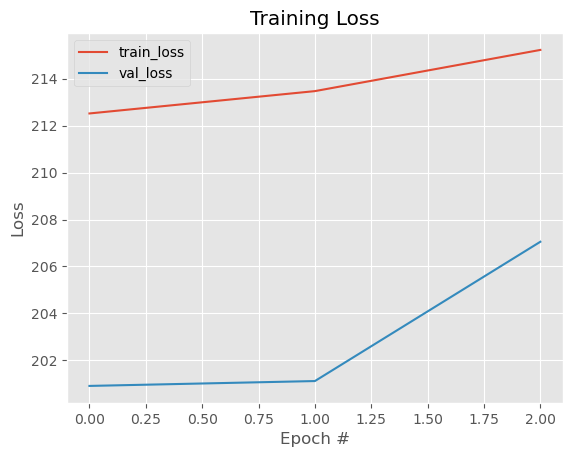

(376510, 602)
lr:  0.05  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: nan - val_loss: nan
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - loss: nan - v

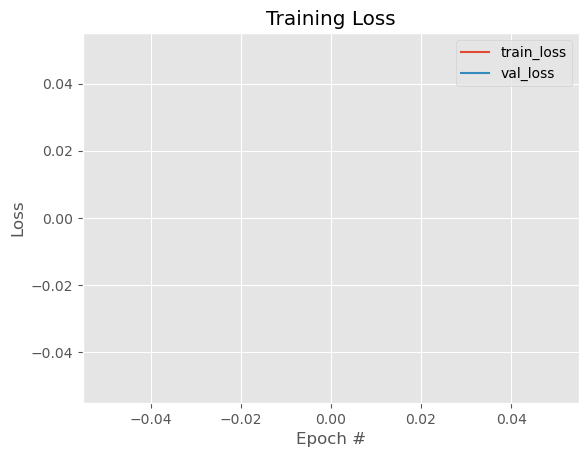

(376510, 608)
lr:  0.05  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 9s 19ms/step - loss: 23.9665 - val_loss: 23.6115
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - loss: 

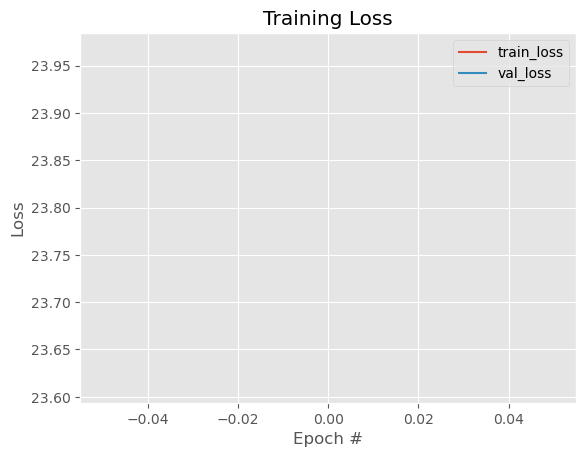

(376510, 708)
lr:  0.05  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 21.8993 - val_loss: 18.7708
Epoch 2/200
471/471 [==============================] - 9s 20ms/step - loss: 27.0864 - val_loss: 23.7905
Epoch 3/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6793 - val_loss: 23.7915
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: 23.6794 - val_loss: 23.7910
Epoch 5/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6792 - val_loss: 23.7910
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: 23.6792 - val_loss: 23.7910
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6795 - val_loss: 23.7904
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 23.6794 - val_loss: 23.7902
Epoch 9/200
471/471 [==============================] - 10s 21ms/step - loss: 23.6794 - val_loss: 23.7903
Epoch 10/2

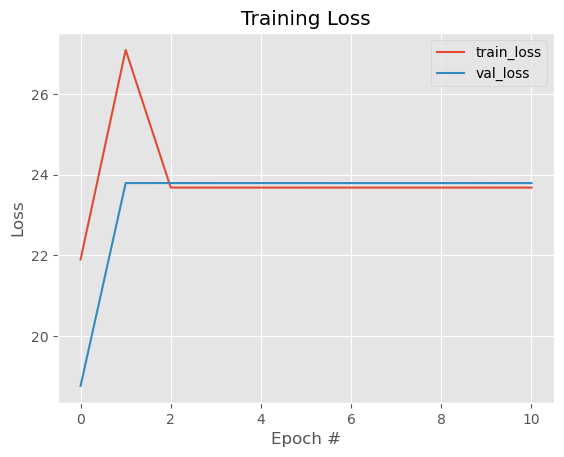

(230311, 590)
lr:  0.05  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 6s 19ms/step - loss: 40.6693 - val_loss: 40.3658
Epoch 2/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5821 - val_loss: 40.3870
Epoch 3/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5824 - val_loss: 40.3867
Epoch 4/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5825 - val_loss: 40.3886
Epoch 5/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5825 - val_loss: 40.3884
Epoch 6/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5838 - val_loss: 40.3969
Epoch 7/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5827 - val_loss: 40.3898
Epoch 8/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5832 - val_loss: 40.4065
Epoch 9/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5838 - val_loss: 40.3860
Epoch 10/200


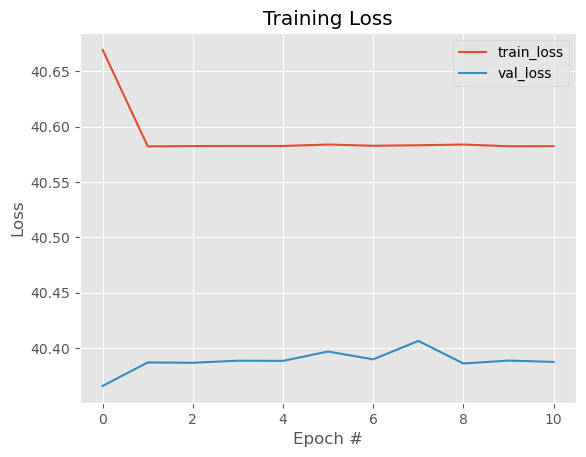

(230311, 596)
lr:  0.05  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 19ms/step - loss: nan - va

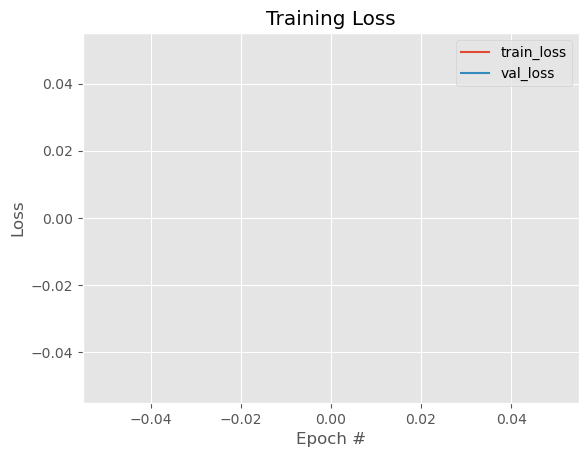

(230311, 696)
lr:  0.05  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 20ms/step - loss: nan - va

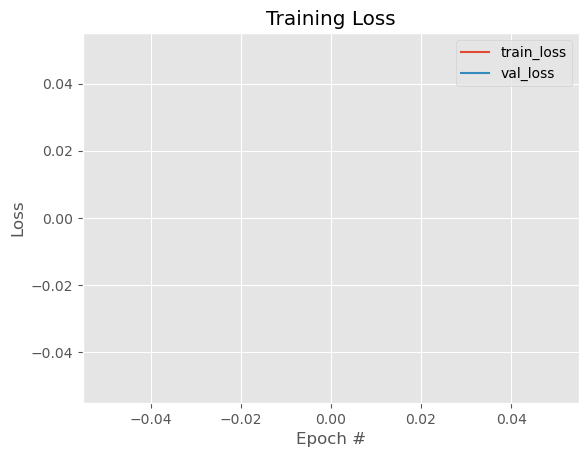

(109080, 582)
lr:  0.05  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 20ms/step - loss: 88.6242 - val_loss: 89.8423
Epoch 2/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4192 - val_loss: 89.7896
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4036 - val_loss: 89.7599
Epoch 4/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4046 - val_loss: 89.7637
Epoch 5/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4048 - val_loss: 89.7618
Epoch 6/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4056 - val_loss: 89.7624
Epoch 7/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4061 - val_loss: 89.7668
Epoch 8/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4071 - val_loss: 89.7630
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4051 - val_loss: 89.7655
Epoch 10/200


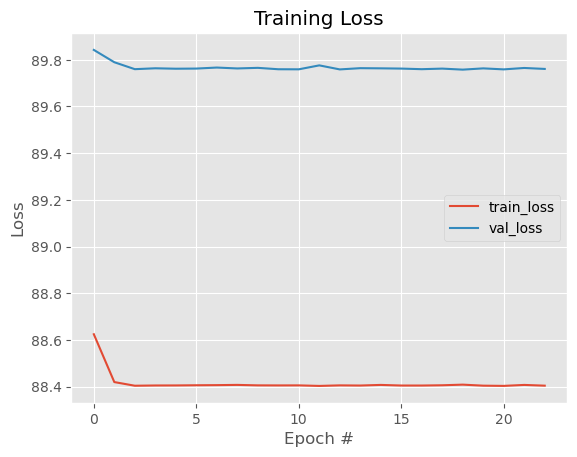

(109080, 588)
lr:  0.05  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 88.7882 - val_loss: 88.1405
Epoch 2/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: 

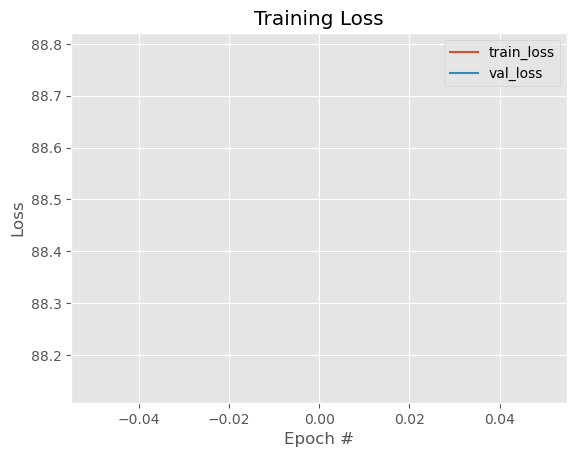

(109080, 688)
lr:  0.05  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 4s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: nan - va

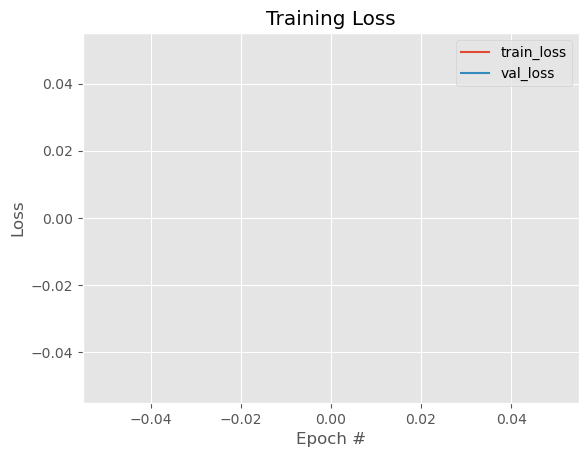

(46168, 579)
lr:  0.05  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 213.7915 - val_loss: 213.2817
Epoch 2/200
58/58 [==============================] - 1s 19ms/step - loss: 213.6245 - val_loss: 215.6625
Epoch 3/200
58/58 [==============================] - 1s 19ms/step - loss: 213.5662 - val_loss: 215.6424
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: 213.5303 - val_loss: 215.6118
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5762 - val_loss: 215.6389
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: 213.3870 - val_loss: 214.5312
Epoch 7/200
58/58 [==============================] - 1s 19ms/step - loss: 214.6486 - val_loss: 215.7520
Epoch 8/200
58/58 [==============================] - 1s 19ms/step - loss: 213.7077 - val_loss: 216.8880
Epoch 9/200
58/58 [==============================] - 1s 19ms/step - loss: 213.7300 - val_loss: 215.6547
Epoch 10/200


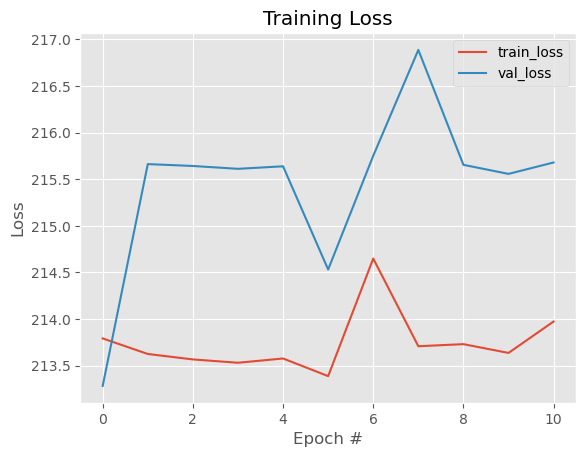

(46168, 585)
lr:  0.05  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 211.1907 - val_loss: 214.4297
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 212.5983 - val_loss: 211.0068
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 19ms/step - loss: nan - va

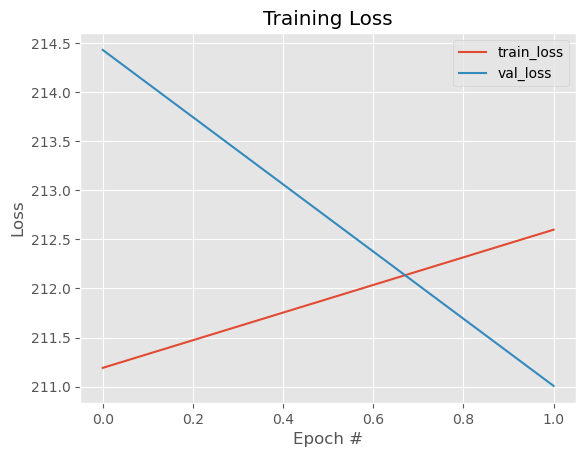

(46168, 685)
lr:  0.05  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: nan - val_loss: nan
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
58/58 [==============================] - 1s 22ms/step - loss: nan - val_loss: nan
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10

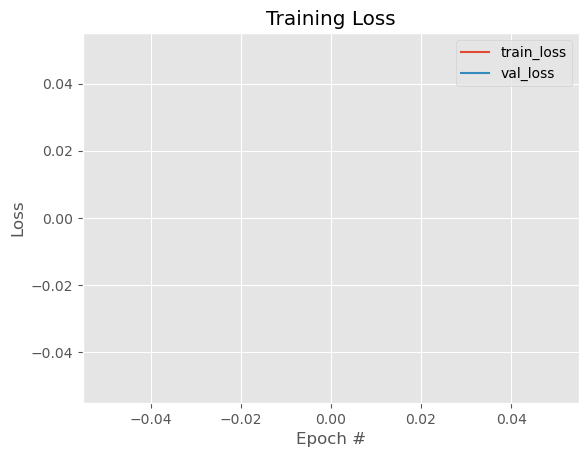

['lr: 0.01 Hour_res: 1 Hex_res: 3 Epochs before stopping:51 Test_loss: 4.6148362159729 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 1 Hex_res: 5 Epochs before stopping:59 Test_loss: 4.64540433883667 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 1 Hex_res: 7 Epochs before stopping:41 Test_loss: 4.577645778656006 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 2 Hex_res: 3 Epochs before stopping:14 Test_loss: 40.885223388671875 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 2 Hex_res: 5 Epochs before stopping:47 Test_loss: 6.94142484664917 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 2 Hex_res: 7 Epochs before stopping:37 Test_loss: 6.900033473968506 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 6 Hex_res: 3 Epochs before stopping:24 Test_loss: 84.2301025390625 Demand mean value: 91.67583425009168',
 'lr: 0.01 Hour_res: 6 Hex_res: 5 Epochs before stopping:14 Test_loss: 74.13087463378906 Demand mean value: 91.675

In [37]:
# training loop, these are the parameters we tested when using h3.
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7]
result_list = []
# sample of 10.000.000 as my computer struggles otherwise.
data_sample = work_data.sample(10000000,random_state=101)
for i in lr:
    for j in resolution:
        for k in hex_res:
            # call the function for creating the dataset.
            data1 = create_dataset_more_data(data_sample,resolution=j,h3_res = k)
            print(data1.shape)

            # defining the network we use.
            network1 = models.Sequential()
            network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(1, activation='linear'))
          
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            # training using the hyperparameters from the loops.
            TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
            loss, H, epochs_plot = TN1.train_net()
            # saving results.            
            result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Hex_res: "+str(k)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list